<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Polynomial_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import math
import pandas as pd
import copy
from datetime import datetime   # useful for date ranges in plots
import matplotlib.pyplot as plt

sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' 'LUX'and 'UK'are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris).

#import os
#os.chdir ('C:\\Users\\odiao\\Desktop\\Model Covid19\\programme_python\\SHR_PA\Code_Python')
#os.getcwd ()
url_belgium = '/COVID19BE_HOSP_2020-07-16.csv'
url_french = '/donnees-hospitalieres-covid19-2020-07-17-19h00_corrected_tmp.csv'
url_lux = '/data_lux.csv'
url_uk = '/data_UK.csv'
# ***********************************************************************************
# Load data Belgium
#**********************************************************
if sw_dataset == 'BEL':   
    # The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
    # This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
    # The link can be reached from https://epistat.wiv-isp.be/covid/
    # Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf

    data_raw = pd.read_csv(url_belgium)
    #fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
# ***********************************************************************************
# Load data French
#**********************************************************       
if sw_dataset == 'FRA':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_french)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("dep"))
# ***********************************************************************************
# Load data Luxembourg
#**********************************************************        
if sw_dataset == 'LUX':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_lux)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("Date"))
# ***********************************************************************************
# Load data United kingdom
#**********************************************************
if sw_dataset == 'UK':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_uk)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("date"))

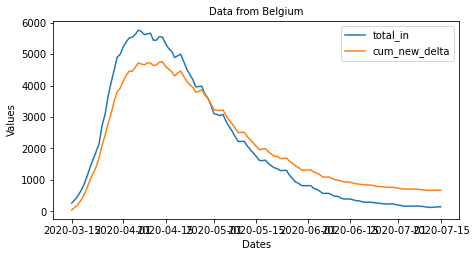

In [16]:
#*********************************
# Start loop on districts
# *******  
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts]) 
    # ***********************************************************************************
    # Process data Belgium
    # *******
    if sw_dataset == 'BEL':

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
        else:   
            data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns

        # Extract relevant data and recompute new_out:
        # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['DATE'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 5
        col_new_out = 6
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
        new_delta = new_in - new_out_raw
        cum_new_delta = np.cumsum(new_delta)
        total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
        # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
        # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
        # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
        new_out = new_in - total_in_chg   # fixed new_out
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns


        # Show Belgian data in figures:
        plt.figure(figsize=(16,8))
        plt.subplot(2,2,1)
        plt.plot(dates, total_in)
        plt.plot(dates,cum_new_delta)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend(("total_in","cum_new_delta"))
        plt.title("Data from Belgium", size=10)
        plt.show(block=False) 

    # Process data France
    # *******
    elif sw_dataset == 'FRA':  # if sw_datset is 'FRA'

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('jour', as_index=False).sum()  # sum over identical dates
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract department cnt_district
        else:
            data_raw_district = data_raw[data_raw.iloc[:,0]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['jour','hosp','rea','rad','dc']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['jour'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_in = np.nan   # no column for new_in in French data
        col_new_out = np.nan  # to get new_out we have to sum 'rad' and 'dc'
        total_in = data_num[:,col_total_in]
        new_out = np.hstack(([0],np.diff(data_num[:,2] + data_num[:,3])))
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        #Plot total_in
        plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from French", size=10)
        plt.show()

    # ***********************************************************************************
    # Process data Luxembourg
    # *******

    elif sw_dataset == 'LUX':  # if sw_datset is 'FRA'

        data = data_raw[['hospi', 'hospintense', 'sortant']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['Date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_out = 2  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_out = data_num[:,col_new_out]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from Luxembourg", size=10)
        plt.show()

    # ***********************************************************************************
    # Process data United kingdom
    # *******

    elif sw_dataset == 'UK':  # if sw_datset is 'FRA'

        data = data_raw[['newAdmissions', 'Hospi']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 0  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_out = new_in - total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from UK", size=10)
        plt.show()

In [21]:
# Define functions for statistics:
def MAPE(y_true, y_pred):  # MAPE is "Mean Absolute Percentage Error"
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
print("******************** FORECAST ACCURACY MEASURES - latex table ********************")
def make_latex_table(stats_all):
    print('\\begin{tabular}{c|c|c}')
    print('\\hline')
    print('Train Interval & MAPE train & MAPE_test \\\\hline')
    print(val, '&', "{:.2f}".format(MAPE_train), '&', "{:.2f}".format(MAPE_test), '\\\\')
    print('\\hline')
    print('\\end{tabular}')
    
x=np.arange(0,len(total_in))
y=np.array(total_in)

for val in [20,40,60,80,100]:
    train_set=total_in[:val]
    test_set=total_in[val:]
    #fitting the model in training period
    x_train=x[0:val]
    y_train=np.array(train_set)
    P = np.poly1d(np.polyfit(x_train, y_train, 15))
    #print('P(X)= ', P)
    #XP_train = np.linspace(0, len(train_set), 100)
    MAPE_train = MAPE(train_set, P(x[:val]))
    #XP_test = np.linspace(len(train_set), len(total_in), 100)
    #x_test= np.arange(len(train_set),len(total_in))
    MAPE_test = MAPE(test_set, P(x[val:]))
    stats_all=val, MAPE_train, MAPE_test
    make_latex_table(stats_all)

******************** FORECAST ACCURACY MEASURES - latex table ********************
\begin{tabular}{c|c|c}
\hline
Train Interval & MAPE train & MAPE_test \\hline
20 & 0.71 & 225407528784881745920.00 \\
\hline
\end{tabular}
\begin{tabular}{c|c|c}
\hline
Train Interval & MAPE train & MAPE_test \\hline
40 & 0.99 & 1172675943182499.25 \\
\hline
\end{tabular}
\begin{tabular}{c|c|c}
\hline
Train Interval & MAPE train & MAPE_test \\hline
60 & 1.81 & 280792256449.32 \\
\hline
\end{tabular}
\begin{tabular}{c|c|c}
\hline
Train Interval & MAPE train & MAPE_test \\hline
80 & 2.32 & 564484482.39 \\
\hline
\end{tabular}
\begin{tabular}{c|c|c}
\hline
Train Interval & MAPE train & MAPE_test \\hline
100 & 3.63 & 2194481.13 \\
\hline
\end{tabular}


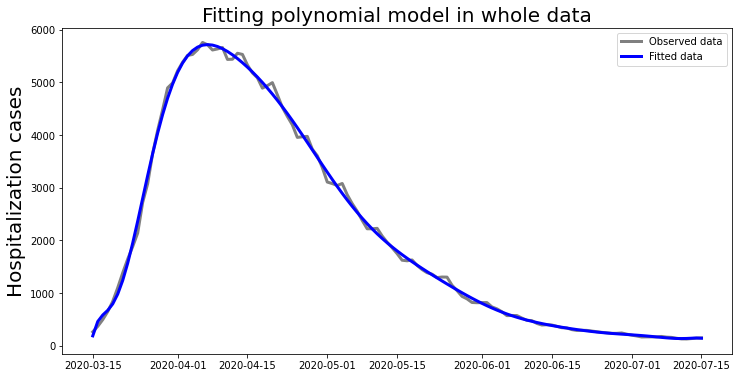

In [37]:
P = np.poly1d(np.polyfit(x, y, 15))
#fitting model in whole data 
fig=plt.figure(figsize = [12, 6])
xp = np.linspace(0, len(total_in), 100)
plt.plot(dates, total_in, "-",color='gray', lw=3, label="Observed data")
plt.plot(dates, P(x), 'b', lw=3,label="Fitted data")
plt.ylabel('Hospitalization cases',size=20)  
plt.title("Fitting polynomial model in whole data", size=20)
plt.legend() 
#fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/poly_belgium.eps')   # save the figure to file
#plt.close(fig)    # close the figure window


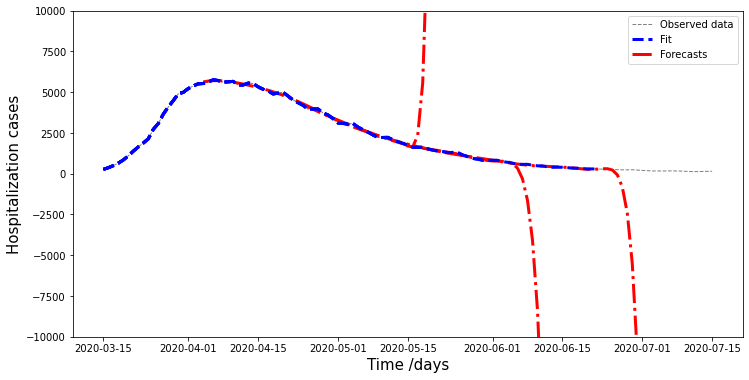

In [40]:
plt.figure(figsize=(12,6))
plt.plot(dates, total_in, '--',color='grey', lw=1)
plt.xlabel('Time /days',size=15)
plt.ylabel('Hospitalization cases',size=15)
plt.ylim(-1e4, 1e4, 1e2)
for val in [20,40,60,80,100]:
    train_set=total_in[:len(total_in)-val]
    test_set=total_in[len(total_in)-val:]
    x_train=np.arange(0,len(train_set))
    y_train=np.array(train_set)
    P = np.poly1d(np.polyfit(x_train, y_train, 15))
    x_test= np.arange(len(train_set),len(total_in))
    #plt.plot(x_train, P(x_train), 'b--',lw=3)
    plt.plot(dates[:val], total_in[:val], 'b--',lw=3)
    #plt.plot(x_test, P(x_test), 'r-.', lw=3)  
    plt.plot(dates[val:], P(x[val:]), 'r-.', lw=3) 
plt.legend(["Observed data","Fit", "Forecasts"])
plt.show()
#fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/poly_belgium.eps')   # save the figure to file
#plt.close(fig)    # close the figure window
